# Autoencoder Métricas
### Obtención de los datos de entrenamiento y validación

In [ ]:
import pickle
import random
import numpy as np

def getMammographyDataset():
    file_path = '/content/dataset/dataset_256_256_CBIS-DDSM_dict.pkl'
    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)

    keys = list(dataset.keys())
    random.shuffle(keys)

    split_index = int(len(keys) * 0.7)

    train_keys = keys[:split_index]
    test_keys = keys[split_index:]

    x_ray_train = np.array([dataset[key]['image_file_numpy'] for key in train_keys])
    y_roi_train = np.array([dataset[key]['roi_mask_file_numpy'] for key in train_keys])

    x_ray_test = np.array([dataset[key]['image_file_numpy'] for key in test_keys])
    y_roi_test = np.array([dataset[key]['roi_mask_file_numpy'] for key in test_keys])

    return (x_ray_train, y_roi_train), (x_ray_test, y_roi_test)

## Evaluación del generador Autoencoder-Unet CON capa de atención

In [ ]:
## CARGA DEL MODELO
import tensorflow as tf
from tensorflow import keras

# Obtener el dataset
(x_ray_train, y_roi_train), (x_ray_test, y_roi_test) = getMammographyDataset()

# Carga el modelo desde el archivo .keras
autoencoder_dca = keras.models.load_model("autoencoder_dca.keras")

In [ ]:
# Generar una imagen a partir de una entrada
decoded_imgs_dca = autoencoder_dca.predict(x_ray_test)
predictions_bin_dca = (decoded_imgs_dca > 0.5).astype(np.uint8)

7/7 ━━━━━━━━━━━━━━━━━━━━ 694s 96s/step


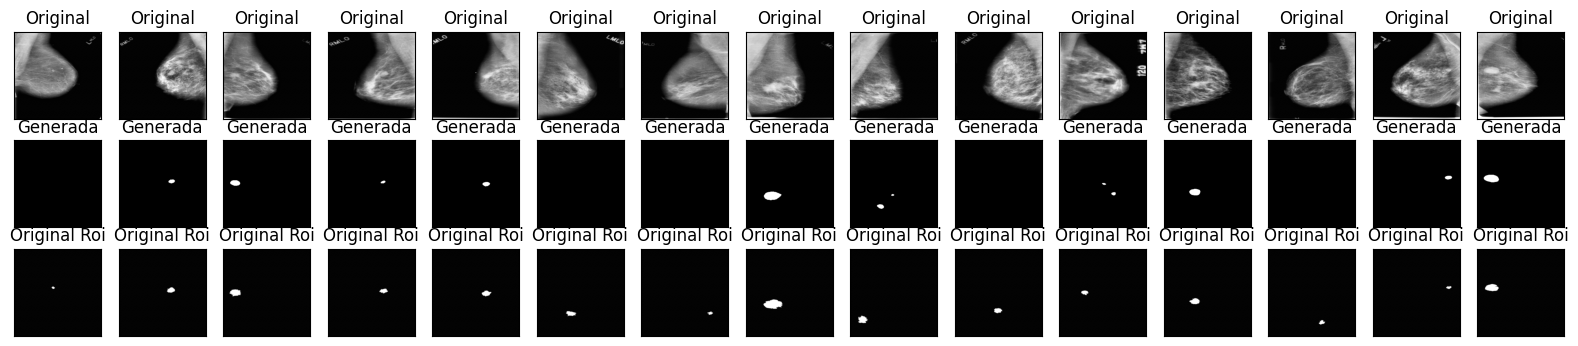

In [ ]:
import matplotlib.pyplot as plt

HEIGHT = 256
WIDTH = 256

# Mostrar las imágenes originales y generadas
n = 15  # Número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Muestra la imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_ray_test[i].reshape(HEIGHT, WIDTH), cmap="gray")
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Muestra la imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(predictions_bin_dca[i].reshape(HEIGHT, WIDTH), cmap="gray")
    plt.title("Generada")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Muestra la imagen original del roi
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(y_roi_test[i].reshape(HEIGHT, WIDTH), cmap="gray")
    plt.title("Original Roi")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
import numpy as np

def dice_coefficient(y_true, y_pred):
    """
    Calcula el coeficiente de Dice entre dos máscaras binarias.

    Parámetros:
    - y_true: np.ndarray, máscara de referencia (ground truth).
    - y_pred: np.ndarray, máscara predicha.

    Retorna:
    - coeficiente de Dice (float).
    """
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    if y_true.shape != y_pred.shape:
        raise ValueError("Las máscaras deben tener la misma forma.")

    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    if total == 0:
      print('vacias')
      return 1.0  # Ambas máscaras están vacías

    return 2.0 * intersection / total

In [ ]:
dice_scores_dca = []

for i in range(len(x_ray_test)):
    y_true = y_roi_test[i].squeeze()
    y_pred = predictions_bin_dca[i].squeeze()

    dice = dice_coefficient(y_true, y_pred)

    dice_scores_dca.append(dice)

In [ ]:
max(dice_scores_dca)

np.float64(0.05306917733850936)

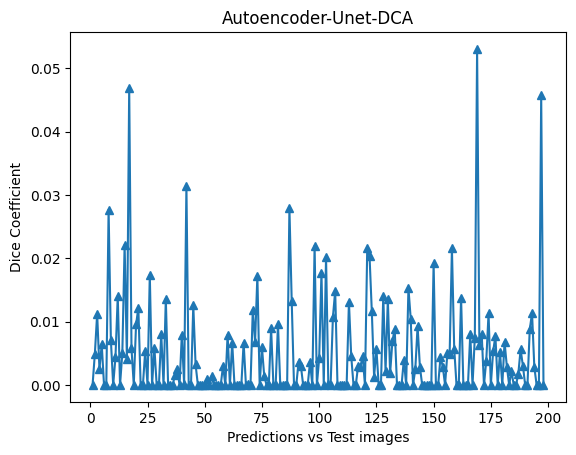

In [ ]:
import matplotlib.pyplot as plt

eje_x = list(range(1, 199))

# Datos de ejemplo
x = eje_x
y = dice_scores_dca

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Trazar los datos
ax.plot(x, y, marker='^')  # 'o' define un marcador circular en cada punto

# Personalizar el gráfico
ax.set_xlabel("Predictions vs Test images")
ax.set_ylabel("Dice Coefficient")
ax.set_title("Autoencoder-Unet-DCA")

# Mostrar el gráfico
plt.show()

## Evaluación del generador Autoencoder-Unet SIN capa de atención

In [ ]:
## CARGA DEL MODELO
import tensorflow as tf
from tensorflow import keras

# Obtener el dataset
#(x_ray_train, y_roi_train), (x_ray_test, y_roi_test) = getMammographyDataset()

# Carga el modelo desde el archivo .keras
autoencoder = keras.models.load_model("unet_autoencoder.keras")

In [ ]:
# Generar una imagen a partir de una entrada
decoded_imgs = autoencoder.predict(x_ray_test)
predictions_bin = (decoded_imgs > 0.5).astype(np.uint8)

7/7 ━━━━━━━━━━━━━━━━━━━━ 479s 67s/step


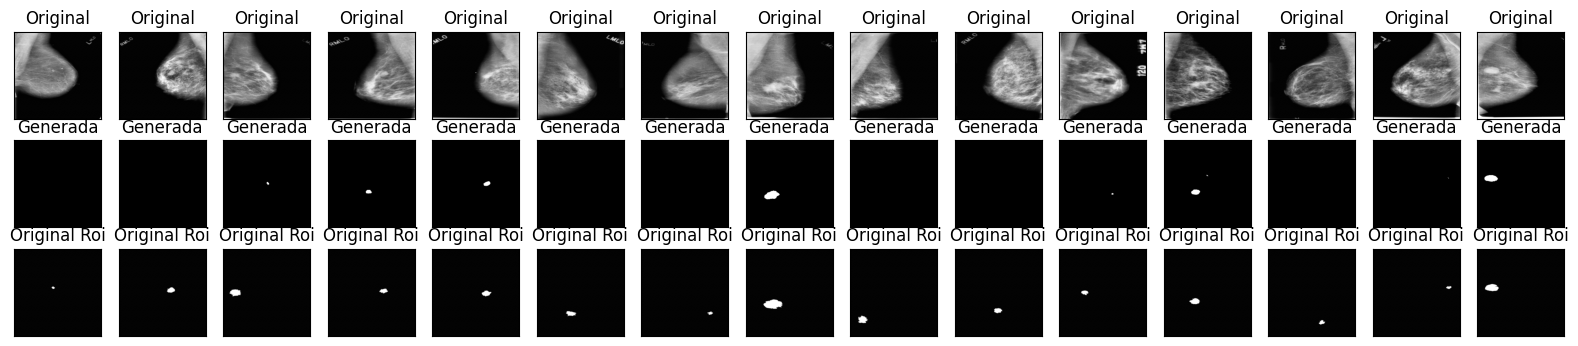

In [ ]:
import matplotlib.pyplot as plt

HEIGHT = 256
WIDTH = 256

# Mostrar las imágenes originales y generadas
n = 15  # Número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Muestra la imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_ray_test[i].reshape(HEIGHT, WIDTH), cmap="gray")
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Muestra la imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(predictions_bin[i].reshape(HEIGHT, WIDTH), cmap="gray")
    plt.title("Generada")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Muestra la imagen original del roi
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(y_roi_test[i].reshape(HEIGHT, WIDTH), cmap="gray")
    plt.title("Original Roi")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
import numpy as np

def dice_coefficient(y_true, y_pred):
    """
    Calcula el coeficiente de Dice entre dos máscaras binarias.

    Parámetros:
    - y_true: np.ndarray, máscara de referencia (ground truth).
    - y_pred: np.ndarray, máscara predicha.

    Retorna:
    - coeficiente de Dice (float).
    """
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)

    if y_true.shape != y_pred.shape:
        raise ValueError("Las máscaras deben tener la misma forma.")

    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    if total == 0:
      print('vacias')
      return 1.0  # Ambas máscaras están vacías

    return 2.0 * intersection / total

In [ ]:
dice_scores = []

for i in range(len(x_ray_test)):
    y_true = y_roi_test[i].squeeze()
    y_pred = predictions_bin[i].squeeze()

    dice = dice_coefficient(y_true, y_pred)

    dice_scores.append(dice)

In [ ]:
max(dice_scores)

np.float64(0.042317591428742446)

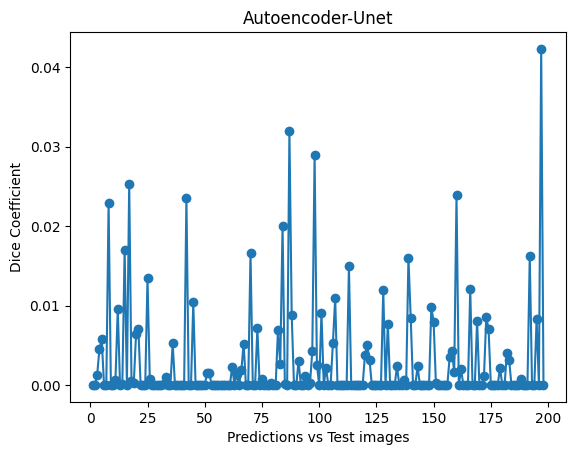

In [ ]:
import matplotlib.pyplot as plt

eje_x = list(range(1, 199))

# Datos de ejemplo
x = eje_x
y = dice_scores

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Trazar los datos
ax.plot(x, y, marker='o')  # 'o' define un marcador circular en cada punto

# Personalizar el gráfico
ax.set_xlabel("Predictions vs Test images")
ax.set_ylabel("Dice Coefficient")
ax.set_title("Autoencoder-Unet")

# Mostrar el gráfico
plt.show()

### Comparación de métricas de autoencoder

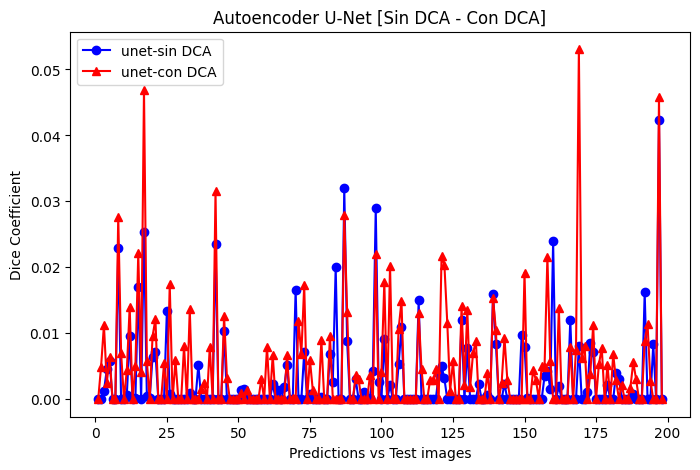

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
x = list(range(1, 199))
y1 = dice_scores
y2 = dice_scores_dca

# Crear la figura y los ejes
plt.figure(figsize=(8, 5))

# Trazar las dos curvas
plt.plot(x, y1, label='unet-sin DCA', color='blue', marker='o')
plt.plot(x, y2, label='unet-con DCA', color='red', marker='^')

# Añadir título y etiquetas
plt.title('Autoencoder U-Net [Sin DCA - Con DCA]')
plt.xlabel('Predictions vs Test images')
plt.ylabel('Dice Coefficient')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

## Evaluación del clasificador

In [ ]:
## Evaluación del clasificador